## Baseline performances and representational similarities across layers
This notebook generates a faceted figure showing layer-wise test balanced accuracy of single-layer probes (AP, CLS, and attentive) across GTSRB and transformer base models, with final-layer markers and multi-layer attentive baselines overlaid for reference.

In [1]:
import pandas as pd
import os
os.chdir("../")
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import re
import numpy as np
from helper import add_additional_info, init_plotting_params, save_or_show, load_sim_matrix
from constants import BASE_PATH_PROJECT, FOLDER_SUBSTRING

In [2]:
init_plotting_params()

{
  "agg.path.chunksize": 0,
  "axes.labelsize": 13.0,
  "axes.titlesize": 14.0,
  "axes3d.trackballsize": 0.667,
  "boxplot.flierprops.markersize": 6.0,
  "boxplot.meanprops.markersize": 6.0,
  "errorbar.capsize": 0.0,
  "figure.figsize": [
    6.4,
    4.8
  ],
  "figure.labelsize": "large",
  "figure.titlesize": "large",
  "font.cursive": [
    "Apple Chancery",
    "Textile",
    "Zapf Chancery",
    "Sand",
    "Script MT",
    "Felipa",
    "Comic Neue",
    "Comic Sans MS",
    "cursive"
  ],
  "font.family": [
    "sans-serif"
  ],
  "font.fantasy": [
    "Chicago",
    "Charcoal",
    "Impact",
    "Western",
    "xkcd script",
    "fantasy"
  ],
  "font.monospace": [
    "DejaVu Sans Mono",
    "Bitstream Vera Sans Mono",
    "Computer Modern Typewriter",
    "Andale Mono",
    "Nimbus Mono L",
    "Courier New",
    "Courier",
    "Fixed",
    "Terminal",
    "monospace"
  ],
  "font.sans-serif": [
    "DejaVu Sans",
    "Bitstream Vera Sans",
    "Computer Modern Sans Serif

In [3]:
project_paths = [
    #BASE_PATH_PROJECT / f"results_{FOLDER_SUBSTRING}_exp",
    BASE_PATH_PROJECT / f"results_{FOLDER_SUBSTRING}_exp_all_intermediate",
    #BASE_PATH_PROJECT /f "results_{FOLDER_SUBSTRING}_rebuttal",
    BASE_PATH_PROJECT / f"results_{FOLDER_SUBSTRING}_combine_aat_ilf",
]

In [4]:
storing_path = BASE_PATH_PROJECT / f"results_{FOLDER_SUBSTRING}_rebuttal/plots/appendix_intermediate_layer_alone_aat_ilf"
SAVE = "both"
if SAVE:
    storing_path.mkdir(parents=True, exist_ok=True)

In [5]:
if True:
    res = []
    for project_path in project_paths:
        print(project_path)
        for res_path in project_path.rglob('seed_0/results.json'):
            if ("linear_probe/single_model" not in str(res_path)) and ("attentive_probe/combined_models" not in str(res_path)):
                continue
            
            df = pd.read_json(res_path)
            #print(df,res_path)
            df = add_additional_info(df)
            
            model_id_n_hopt_slug = "/".join(res_path.parts[10:-1])
            df['model_id_n_hopt_slug'] = model_id_n_hopt_slug
            df['res_folder'] = project_path.name
    
            res.append(df)
    all_results = pd.concat(res).reset_index(drop=True)
    all_results["probe_type"]= "cae"
runs_rebuttal = pd.read_pickle(BASE_PATH_PROJECT / f"results_{FOLDER_SUBSTRING}_rebuttal/aggregated/all_runs_rebuttal.pkl")
runs_old = pd.read_pickle(BASE_PATH_PROJECT / f"results_{FOLDER_SUBSTRING}_exp/aggregated" / f'all_runs_v11.pkl')
runs_old["probe_type"]="cae"
all_results = pd.concat([all_results,runs_old,runs_rebuttal]).reset_index(drop=True)
aat_ilf = all_results[all_results["Experiment"]=="All tokens from quarterly blocks (attentive)"]
all_results = all_results[all_results["Experiment"]!="All tokens from quarterly blocks (attentive)"]

/home/space/rep2rep/results_iclr_exp_all_intermediate
/home/space/rep2rep/results_iclr_combine_aat_ilf


/tmp/ipykernel_2075450/1304393839.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat(res).reset_index(drop=True)


In [6]:
ds_list = ['wds/gtsrb', ]
ds_list_relpaced = ['wds_gtsrb', ]
model_list = ['CLIP-B-16', 'DINOv2-B-14', 'ViT-B-16']
all_results = all_results[
    all_results['dataset'].isin(ds_list) & \
    all_results['base_model_fmt'].isin(model_list)
].copy().reset_index(drop=True)

In [7]:
all_results['block_layer'] = all_results['model_ids'].apply(lambda x: eval(x)[0].split("@")[1] if len(eval(x))==1 else "multi")
def parse_block_layer(block_layer):
    if block_layer in ['norm', 'visual']:
        return "last"
    match = re.search(r'\.(\d+)\.', block_layer)
    if match:
        return match.group(1)
    if "multi" in block_layer:
        return "multi"
    return 'unknown'

all_results['block_layer'] = all_results['block_layer'].apply(parse_block_layer)
all_results = all_results[all_results['block_layer'] != '0' ].copy().reset_index(drop=True)
all_results.loc[:,'layer_types'] = all_results.loc[:,'layer_types'].map({'cls+avg_pool': "Linear probe on CLS and AP", 'avg_pool': "Linear probe on AP", 'cls': "Linear probe on CLS", "all_tokens_last_layer": "AAT"})
all_results.loc[:,'layer_types'] = all_results.loc[:,'layer_types'].map({"Linear probe on CLS and AP": "Single Layer (CLS+AP, Linear)" ,"Linear probe on AP": "Single Layer (AP, Linear)", "Linear probe on CLS":"Single Layer (CLS, Linear)",
                                                                         "AAT":"Single Layer (all tokens, attentive)"})


In [8]:
base_path = BASE_PATH_PROJECT / f"model_similarities_{FOLDER_SUBSTRING}"
sim_metrics = [
    'cka_kernel_linear_unbiased',
    'cka_kernel_rbf_unbiased_sigma_0.2'
]

In [9]:
def sort_key(item):

    if '_cls@' in item:
        token_type = 0  
    elif '_ap@' in item:
        token_type = 1 
    else:
        token_type = 2
    match = re.search(r'\.(\d+)\.', item)
    if match:
        block_num = int(match.group(1))
    else:
        block_num = np.inf 
    return (token_type, block_num)

res = dict()
for path in base_path.rglob("similarity_matrix.pt"):
    ds = path.parts[5]
    if ds not in ds_list_relpaced:
        continue
    sim_metric = path.parts[6]
    model = path.parts[7]
    curr_sim_mat = load_sim_matrix(path.parent, allowed_models=None)
    sorted_list = sorted(curr_sim_mat.index.to_list(), key=sort_key)
    curr_sim_mat = curr_sim_mat.loc[sorted_list, sorted_list]
    np.fill_diagonal(curr_sim_mat.values, 1)
    if sim_metric not in res.keys():
        res[sim_metric] = {}
    if ds not in res[sim_metric].keys(): 
        res[sim_metric][ds] = {}
    res[sim_metric][ds][model] = curr_sim_mat

stored image.


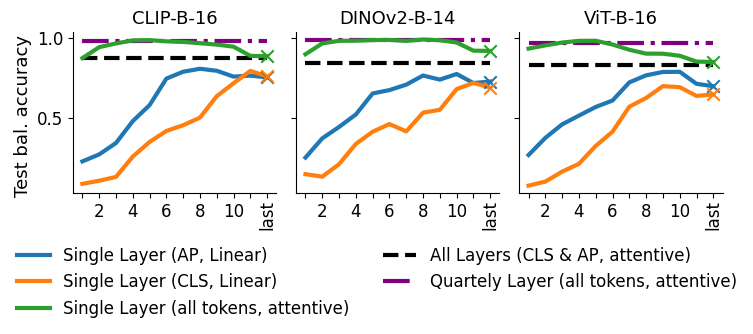

In [10]:

plt.rcParams['text.usetex'] = False
order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 'last']
SIM_METRIC = sim_metrics[0] 
offset = 2
color_map = {
    'CLIP-B-16':list(plt.cm.tab20c.colors)[8 + offset], 
    'DINOv2-B-14':list(plt.cm.tab20c.colors)[12+ offset], 
    'ViT-B-16':list(plt.cm.tab20b.colors)[12+ offset], 
    'OpenCLIP_ViT-B-16_openai':list(plt.cm.tab20c.colors)[8+ offset], 
    'dinov2-vit-base-p14':list(plt.cm.tab20c.colors)[12+ offset], 
    'vit_base_patch16_224': list(plt.cm.tab20b.colors)[12+ offset], 
    'MAE-B-16': list(plt.cm.tab20b.colors)[16+ offset],
    'mae-vit-base-p16': list(plt.cm.tab20b.colors)[16+ offset],
}
#all_results_filtered = all_results[all_results["layer_types"].isin(["Linear probe on AP", "Linear probe on CLS", "AAT"]) ]
all_results_filtered = all_results[all_results["layer_types"].isin(["Single Layer (AP, Linear)", "Single Layer (CLS, Linear)", "Single Layer (all tokens, attentive)"]) ]
all_results_filtered

linewidth = 3

g = sns.relplot(
    all_results_filtered.sort_values(by='block_layer', key=lambda x: x.apply(lambda y: order.index(y))),
    x='block_layer', 
    y='test_lp_bal_acc1',
    hue='layer_types',               # <--- NEW
    hue_order=["Single Layer (AP, Linear)", "Single Layer (CLS, Linear)", "Single Layer (all tokens, attentive)"],#["Linear probe on AP", "Linear probe on CLS", "AAT"], 
    #col='dataset_fmt',
    #row='base_model_fmt',            # <--- NEW
    row='dataset_fmt',
    col='base_model_fmt',            # <--- NEW
    col_order=model_list,
    facet_kws={'sharey':"row"},
    kind='line',
    height=2.5,
    aspect=1,
    linewidth=linewidth,
)
# --- Add a square marker on the last point for "Single Layer (all tokens, attentive)" ---
target_layers = [
    "Single Layer (AP, Linear)",
    "Single Layer (CLS, Linear)",
    "Single Layer (all tokens, attentive)"
]

hue_order = ["Single Layer (AP, Linear)", "Single Layer (CLS, Linear)", "Single Layer (all tokens, attentive)"]

# Grab the palette seaborn used for the current plot (number of colors = number of hues)
palette = sns.color_palette(n_colors=len(hue_order))
palette_map = dict(zip(hue_order, palette))

for i_row in range(g.axes.shape[0]):
    for j_col in range(g.axes.shape[1]):
        ax = g.axes[i_row, j_col]

        for layer_type in target_layers:

            # data subset in this facet + this layer type
            facet_data = all_results_filtered[
                (all_results_filtered["dataset_fmt"] == g.row_names[i_row]) &
                (all_results_filtered["base_model_fmt"] == g.col_names[j_col]) &
                (all_results_filtered["layer_types"] == layer_type)
            ].sort_values(by='block_layer', key=lambda x: x.apply(lambda y: order.index(y)))

            if len(facet_data) == 0:
                print("last not found", layer_type)
                continue

            # last point
            last_x_label = facet_data["block_layer"].iloc[-1]
            last_y = facet_data["test_lp_bal_acc1"].iloc[-1]
            last_x = order.index(last_x_label)


            #color = line.get_color()
            
            color = palette_map.get(layer_type, "black")

            # draw square marker
            ax.scatter(
                [last_x], [last_y],
                marker="x",
                s=80,
                facecolor=color,
                #edgecolor="black",
                zorder=10,
            )
for ax_row in g.axes:
    for ax in ax_row:
        labels = ax.get_xticklabels()

        for i, label in enumerate(labels):
            txt = label.get_text()

            if (i % 2 == 1) or (txt == "last"):
                label.set_visible(True)
            else:
                label.set_visible(False)

            if txt == "last":
                label.set_rotation(90)
                label.set_va("center")
                label.set_ha("center")
                label.set_y(-0.075)


def get_similarities(curr_sim_mat, is_cls=False):
    n_layers = curr_sim_mat.shape[0]
    if is_cls:
        return curr_sim_mat.iloc[(n_layers // 2)-1, 1 : (n_layers // 2)]
    else:
        return curr_sim_mat.iloc[n_layers-1, (n_layers // 2) + 1 :]        

def plot_cka_new(data, *args, **kwargs):

    # ------- find dataset -------
    ds = data['dataset'].unique()
    assert len(ds) == 1
    ds = ds[0].replace('/', '_')

    # ------- find layer type (to detect CLS only) -------
    layer_type = data['layer_types'].unique()
    
    if len(layer_type) != 1:
        print(layer_type)
        layer_type = ["Single Layer (CLS, Linear)"]#["Linear probe on CLS"]
    layer_type = layer_type[0]

    if layer_type != "Single Layer (CLS, Linear)":#"Linear probe on CLS":
        return  # <-- Only plot the CLS-based CKA line

    # ------- find model (one model per row now) -------
    base_model = data['base_model'].unique()
    assert len(base_model) == 1
    base_model = base_model[0]

    # ------- extract CKA similarity -------
    curr_sim_mat = res[SIM_METRIC][ds][f"{base_model}_both"]
    
    # CLS similarities come from the middle block:
    n_layers = curr_sim_mat.shape[0]
    curr_sims = curr_sim_mat.iloc[(n_layers // 2) - 1, 1:(n_layers // 2)]

    # ------- plot on current axis -------
    ax = plt.gca()
    ax.plot(
        ax.get_xticks(),
        curr_sims,
        color="black",
        linestyle=':',
        linewidth=linewidth,
        zorder=-1
    )

g.set_titles("{col_name}")
g.set_xlabels("")


for i, layer_type in enumerate(g.row_names):
    #g.axes[i, 0].set_ylabel(f"{layer_type}\n\nTest bal. accuracy (solid) \n\n CKA similarity (dotted)")
    g.axes[i, 0].set_ylabel(f"Test bal. accuracy ")

for i in range(len(g.row_names)):
    for j in range(1, g.axes.shape[1]):
        g.axes[i, j].set_ylabel("")

for i in range(1, g.axes.shape[0]): 
    for j in range(0, g.axes.shape[1]):
        g.axes[i, j].set_title("")

#g.map_dataframe(plot_cka_new)

g.fig.tight_layout()

baseline_results = all_results[all_results["layer_types"].isin([ "Single Layer (CLS+AP, Linear)"]) &\
    all_results["nr_layers"].isin([24]) &\
    #all_results["base_model"].isin(["dinov2-vit-base-p14"]) 
    all_results["task"].isin(["attentive_probe"]) &\
    all_results["probe_type"].isin(["cae"])
    ]#["model_ids"].value_counts()


def plot_baseline(data, *args, **kwargs):
    # dataset in this facet
    ds = data['dataset'].unique()
    assert len(ds) == 1
    ds = ds[0]

    # model in this facet
    model = data['base_model'].unique()
    assert len(model) == 1
    model = model[0]

    # look up the baseline value
    row = baseline_results[
        (baseline_results["dataset"] == ds) &
        (baseline_results["base_model"] == model)
    ]

    if len(row) == 0:
        print("no Baseline?")
        return  # no baseline for this combination
    baseline_value = row["test_lp_bal_acc1"].iloc[0]

    ax = plt.gca()
    xticks = ax.get_xticks()
    xmin = xticks[0]
    xmax = xticks[-1]

    # draw the horizontal baseline
    ax.hlines(
        y=baseline_value,
        xmin=xmin,
        xmax=xmax,
        color="black",
        linestyle="--",
        linewidth=linewidth,
        zorder=-2
    )
    if True:
        row_2 = aat_ilf[(aat_ilf["dataset"] == ds) &
        (aat_ilf["base_model"] == model)]
        if len(row_2) == 0:
            print("no Baseline?")
            return  # no baseline for this combination
        baseline_value = row_2["test_lp_bal_acc1"].iloc[0]
        # draw the horizontal baseline
        ax.hlines(
            y=baseline_value,
            xmin=xmin,
            xmax=xmax,
            color="purple",
            linestyle="-.",
            linewidth=linewidth,
            zorder=-2
        )
g.map_dataframe(plot_baseline)
#sns.move_legend(g, loc="upper left", bbox_to_anchor=(0.85,0.65), title="Model")

baseline_handle = Line2D(
    [], [], 
    color="black",
    linestyle="--",
    linewidth=linewidth,
    label="All Layers (CLS+AP, attentive)"
)
baseline_handle_2 = Line2D(
    [], [], 
    color="purple",
    linestyle="-.",
    linewidth=linewidth,
    label="Quartely Layer (all tokens, attentive)"
)
# Remove panel-level legend
if g._legend is not None:
    g._legend.remove()

# Extract handles from any subplot
handles, labels = g.axes[0][0].get_legend_handles_labels()

# Add baseline
handles.append(baseline_handle)
labels.append("All Layers (CLS & AP, attentive)")
handles.append(baseline_handle_2)
labels.append("Quartely Layer (all tokens, attentive)")


# Add bottom legend
g.fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    ncol=2,#len(labels),
    frameon=False,
    bbox_to_anchor=(0.345, -0.35),
)

fn = storing_path / f'cka_{"local" if "rbf" in SIM_METRIC else "global"}_vs_test_bal_acc_intermediate_layers_with_aatilf_only_gtsrb.pdf'
save_or_show(g.fig, fn, SAVE)